In [2]:
%run nbloader.py

import matplotlib
%matplotlib inline
import seaborn
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib import pyplot as plt
import root_numpy
import pandas as pd
import numpy as np
from numba import jit

from sklearn.svm import SVC
from sklearn.cluster import DBSCAN
from sklearn.ensemble import RandomForestClassifier


from pystruct.models import ChainCRF
from pystruct.learners import FrankWolfeSSVM


from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split

from multiprocessing import Pool
BRICK_X = 124000
BRICK_Y = 99000
BRICK_Z = 75000
SAFE_M = 10000
dZ = 205
LAYER_DIFF = 1293

from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import normalization
from keras.layers import SimpleRNN
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

Using Theano backend.


In [3]:
# Data Procsseing

In [4]:
def load_mc(filename="data/mcdata2.root", step=1):
    mc = root_numpy.root2array(
                        filename,
                        treename="Data",
                        branches=["Event_id", "ele_P",
                                   "BT_X", "BT_Y", "BT_Z",
                                   "BT_SX", "BT_SY", "BT_plate",
                                   "ele_x", "ele_y", "ele_z", 
                                   "ele_sx", "ele_sy", 
                                   "chisquare", "alfa", "deltaSx", "deltaSy"],
                        step=step)
    pmc = pd.DataFrame(mc)
    pmc['numtracks'] = pmc.BT_X.apply(lambda x: len(x))
    # cuts
    shapechange = [pmc.shape[0]]
    pmc = pmc[pmc.ele_P > 0.1]
    shapechange.append(pmc.shape[0])
    pmc = pmc[pmc.ele_x.abs() < BRICK_X / 2 - SAFE_M]
    shapechange.append(pmc.shape[0])
    pmc = pmc[pmc.ele_y.abs() < BRICK_Y / 2 - SAFE_M]
    shapechange.append(pmc.shape[0])
    pmc = pmc[pmc.ele_z < 0]
    shapechange.append(pmc.shape[0])
    pmc = pmc[pmc.numtracks > 100]
    shapechange.append(pmc.shape[0])
    # Delete chi2 > 3
    pmc['chisquare'] = pmc.chisquare.apply(lambda x: x[x < 3])
    print("Check chi2 < 3", (pmc.numtracks == pmc.chisquare.apply(lambda x : len(x))).all())
    
    
    print ("numtracks reduction by cuts: ", shapechange)
    pmc.BT_X += BRICK_X / 2
    pmc.BT_Y += BRICK_Y / 2
    pmc.BT_Z += BRICK_Z / 2
    pmc.ele_x += BRICK_X / 2
    pmc.ele_y += BRICK_Y / 2
    pmc.ele_z += BRICK_Z / 2

    pmc.BT_Z = (pmc.BT_plate - 1) * 1293
    
    return pmc

def load_bg(step=10000):
    # ignore 57th layer since it looks different
    etalon_plates = []
    for p in range(48, 57):
        backtracks = root_numpy.root2array("data/129294.{p}.1.1000.cp.root".format(p=p), 
                                       treename="couples", 
                                       branches=["s.eX", "s.eY", "s.eZ",
                                                "s.eTX", "s.eTY",
                                                "s.eChi2"], step=step)
        etalon_plates.append(backtracks)
        
    df = None
    for p in range(58):
        plate = np.copy(etalon_plates[p % len(etalon_plates)])
        plate['s.eZ'] = p * 1293
        if df is None:
            df = pd.DataFrame(plate)
        else:
            df = pd.concat([df, pd.DataFrame(plate)], ignore_index=True)
    df['plate_index'] = df['s.eZ'].astype('category').cat.codes + 1
    print ("bg: {n} tracks".format(n=df.shape[0]))
    return df

BT_Z_unique = np.array([     0.,   1293.,   2586.,   3879.,   5172.,   6465.,   7758.,
                          9051.,  10344.,  11637.,  12930.,  14223.,  15516.,  16809.,
                         18102.,  19395.,  20688.,  21981.,  23274.,  24567.,  25860.,
                         27153.,  28446.,  29739.,  31032.,  32325.,  33618.,  34911.,
                         36204.,  37497.,  38790.,  40083.,  41376.,  42669.,  43962.,
                         45255.,  46548.,  47841.,  49134.,  50427.,  51720.,  53013.,
                         54306.,  55599.,  56892.,  58185.,  59478.,  60771.,  62064.,
                         63357.,  64650.,  65943.,  67236.,  68529.,  69822.,  71115.,
                         72408.,  73701.])

# old_params
# BRICK_X_MIN = 27762
# BRICK_X_MAX = 72240
# BRICK_Y_MIN = 3312
# BRICK_Y_MAX = 76710

BRICK_X_MIN = 28500
BRICK_X_MAX = 71500
BRICK_Y_MIN = 3800
BRICK_Y_MAX = 76400

def shift_mc_data_with_margin(pmc, pbg, x_safe_margin = 0, y_safe_margin = 0):
    pmc_new = pmc.copy()
    mc_range = (pmc['ele_x'].max() - pmc['ele_x'].min(), pmc['ele_y'].max() - pmc['ele_y'].min())
    def coordinate_mover(x, min_mc_coord, amplitude, margin):
        return ((x - min_mc_coord) / amplitude - 0.5) * 2* (- margin - (left_bound - right_bound) / 2) +\
                (left_bound + right_bound) / 2
    
    right_bound = pbg['s.eX'].max()
    left_bound = pbg['s.eX'].min()
    
    pmc_new.ele_x = coordinate_mover(pmc.ele_x, pmc['ele_x'].min(), mc_range[0], x_safe_margin)
    pmc_new.BT_X = pmc['BT_X'] - (pmc['ele_x'] - pmc_new.ele_x)
    
    right_bound = pbg['s.eY'].max()
    left_bound = pbg['s.eY'].min()    
    
    pmc_new.ele_y = coordinate_mover(pmc.ele_y, pmc['ele_y'].min(), mc_range[1], y_safe_margin)
    pmc_new.BT_Y = pmc['BT_Y'] - (pmc['ele_y'] - pmc_new.ele_y)
    return pmc_new

def combine_mc_bg(pmc, pbg, events = [0], bg_frac=0.1):
    '''Create mixed DataFrame from selected MC Even_Id's and
       fraction of background'''
    #first of all generate background with random permutation by Z-axis
    
    pbg_frac = pbg.sample(frac=bg_frac)
    pbg_frac['s.eZ'] = np.random.choice(BT_Z_unique, size=len(pbg_frac))
    print("Z coords generated")
    dmix = pbg_frac[['s.eX', 's.eY', 's.eZ', 's.eTX', 's.eTY', 's.eChi2']]
    dmix.columns = ['X', 'Y', 'Z', 'TX', 'TY', 'chi2']

    mapping = dict((k,v) for (k,v) in zip(BT_Z_unique, range(1, len(BT_Z_unique) + 1)))
    
    dmix['plate_number'] = pbg_frac['s.eZ'].apply(lambda x: mapping[x])

    dmix['signal'] = False
    dmix['event_id'] = -999

    print("Number of BG basetracks:", dmix.shape[0])
    #now we are generating signal by shifting electron position
    
    pmc_new = shift_mc_data_with_margin(pmc, pbg, 10000, 10000)
    
    pmc_new['chisquare'] = pmc_new.chisquare.apply(lambda x: x[x < 3]) 
    df = pmc_new[pmc_new.Event_id.isin(events)]
    
    print("Number of MC events:", df.shape[0])
    
    dmc = pd.DataFrame()
    dmc['X'] = np.hstack(df.BT_X)
    dmc['Y'] = np.hstack(df.BT_Y)
    dmc['Z'] = np.hstack(df.BT_Z)
    dmc['TX'] = np.hstack(df.BT_SX)
    dmc['TY'] = np.hstack(df.BT_SY)
    dmc['chi2'] = np.hstack(df.chisquare)
    dmc['plate_number'] = np.hstack(df.BT_plate)
    dmc['signal'] = True
    dmc['event_id'] = np.repeat(df.Event_id.values, df.numtracks.values)

    # delete events which are out of bounds
    clear_signal = dmc[~dmc.event_id.isin(dmc.event_id[(dmc.X > BRICK_X_MAX) |
                                                    (dmc.X < BRICK_X_MIN) |
                                                    (dmc.Y > BRICK_Y_MAX) |
                                                    (dmc.Y < BRICK_Y_MIN)].unique())]
    
    print("Number of MC events in bounds:", len(clear_signal.event_id.unique()))
        
    dd = pd.concat([dmix, clear_signal], ignore_index=True)

    return dd, df

In [5]:
# Utils

In [6]:
def compute_track_continuation(track):
    return track[0] + LAYER_DIFF * track[3], track[1] + LAYER_DIFF * track[4]

def precision_recall(cleared_data, original_shower_size):
    tp = np.sum(cleared_data.signal == 1) + 0.
    fp = np.sum(cleared_data.signal == 0)
    precision = tp / (tp + fp)
    recall = tp / original_shower_size
    return [precision, recall]

def metric_track(parent, son):
    if abs(parent[2] - son[2]) > 1500:
        return 10000.
    if parent[2] < son[2]:
        diff = np.append(parent[3:5], 1)
        return np.linalg.norm(np.cross(son[:3] - parent[:3] -  diff, son[:3] - parent[:3]))/np.linalg.norm(diff)
    else:
        diff = np.append(son[3:5], 1)
        return np.linalg.norm(np.cross(parent[:3] - son[:3] -  diff, parent[:3] - son[:3]))/np.linalg.norm(diff)
    
def calculate_shower_loss(list_of_showers, cleared_tracks):
    loss = 0
    for shower in list_of_showers:
        dominating_id = shower.event_id.value_counts().argmax()
        dominating_id_counts = (shower.event_id == dominating_id).sum()
        hits_rate =   float((dominating_id_counts - (shower.shape[0] - dominating_id_counts)))/\
                      float((cleared_tracks.event_id == dominating_id).sum())
            
        loss += hits_rate
    return loss / len(list_of_showers)

In [7]:
# Plots

In [8]:
def plot_multiple_showers(list_of_showers, step = 1, azim = 0, elev = 0):
    colors = np.random.permutation(list(matplotlib.colors.cnames))
    collection = []
    for df, color in zip(list_of_showers, colors):
        d0 = pd.DataFrame([
                    df['Z'][::step],
                    df['X'][::step],
                    df['Y'][::step]],
                    index=['z', 'x', 'y']).T
        numtracks = d0.shape[0]
        dd = pd.DataFrame([
                df['TX'][::step]*dZ,
                df['TY'][::step]*dZ],
                index=['x', 'y']).T
        dd.insert(loc=0, column='z', value=dZ)
        d1 = d0 + dd
        if len(list_of_showers) == 1:
            color = 'red'
        collection.append(Line3DCollection(list(zip(d0.values, d1.values)), colors=color, alpha=0.5, lw=2))


    
    fig = plt.figure(figsize=(12,8))
    ax = fig.gca(projection='3d')
    ax.view_init(azim=azim, elev=elev)
    
    for elem in collection:
        ax.add_collection3d(elem)


    ax.set_xlabel("z")
    ax.set_ylabel("x")
    ax.set_zlabel("y")  
    ax.set_xlim(0, BRICK_Z)
    ax.set_ylim(0, BRICK_X)
    ax.set_zlim(0, BRICK_Y)

def plot_bg_and_mc(pbg, pmc, id=0, step=1):
    df = pbg
    # mind the order!
    d0 = pd.DataFrame([
                df['Z'][::step],
                df['X'][::step],
                df['Y'][::step]],
                index=['z', 'x', 'y']).T
    numtracks = d0.shape[0]
    dd = pd.DataFrame([
            df['TX'][::step]*dZ,
            df['TY'][::step]*dZ],
            index=['x', 'y']).T
    dd.insert(loc=0, column='z', value=dZ)
    d1 = d0 + dd
    # print d0, d1
    C = plt.cm.Blues(0.5)
    lc_bg = Line3DCollection(list(zip(d0.values, d1.values)), colors=C, alpha=0.5, lw=2)

    df = pmc

    # mind the order!
    d0 = pd.DataFrame([
                df['Z'],
                df['X'],
                df['Y']],
                index=['z', 'x', 'y']).T
    numtracks = d0.shape[0]
    dd = pd.DataFrame([
            df['TX']*dZ,
            df['TY']*dZ],
            index=['x', 'y']).T
    dd.insert(loc=0, column='z', value=dZ)
    d1 = d0 + dd
    print(d1.shape)
    #print (d0)§
    C = plt.cm.Reds(0.5)
    lc_mc = Line3DCollection(list(zip(d0.values, d1.values)), colors=C, alpha=0.9, lw=2)
    
    fig = plt.figure(figsize=(12,8))
    ax = fig.gca(projection='3d')
    ax.view_init(azim=-40, elev=15)
    ax.add_collection3d(lc_mc)
    ax.add_collection3d(lc_bg)
    
    # mind the order!
    ax.set_xlabel("z")
    ax.set_ylabel("x")
    ax.set_zlabel("y")  
    ax.set_xlim(0, BRICK_Z)
    ax.set_ylim(0, BRICK_X)
    ax.set_zlim(0, BRICK_Y)
    
def plot_pairs(d0, d1, df):
    dZ = 205

    # mind the order!
    d00 = pd.DataFrame([
                df['Z'][:],
                df['X'][:],
                df['Y'][:]],
                index=['z', 'x', 'y']).T
    numtracks = d00.shape[0]
    dd = pd.DataFrame([
            df['TX'][:]*dZ,
            df['TY'][:]*dZ],
            index=['x', 'y']).T
    dd.insert(loc=0, column='z', value=dZ)
    d11 = d00 + dd

    C = plt.cm.Blues(0.5)
    lc = Line3DCollection(zip(d00.values, d11.values), colors=C, alpha=0.5, lw=2)
    numtracks = len(d0[:, 0])
    

    C = plt.cm.Reds(0.5)
    lb = Line3DCollection(zip(d0[:, [2, 0, 1]], d1[:, [2, 0, 1]]), colors=C, alpha=0.9, lw=2)

    fig = plt.figure(figsize=(12,8))
    ax = fig.gca(projection='3d')
    ax.view_init(azim=-103, elev=16)
    ax.add_collection3d(lc)
    ax.add_collection3d(lb)

    ax.set_xlabel("z")
    ax.set_ylabel("x")
    ax.set_zlabel("y")
    ax.set_xlim(d0[:, 2].min(), d0[:, 2].max())
    ax.set_ylim(d0[:, 0].min(), d0[:, 0].max())
    ax.set_zlim(d0[:, 1].min(), d0[:, 1].max())

In [9]:
# Training samples generator. Pairwise.

In [10]:
def construct_signal_pairs(data, id, ip_threshold):    
    parents = list()
    sons = list()

    shower = data[data.event_id == id].values

    z_coordinates = list(set(shower[:, 2]))
    z_coordinates.sort()
    for i in range(len(z_coordinates) - 1):
        for track in shower[shower[:, 2] == z_coordinates[i] ,:]:
            next_layer = shower[shower[:, 2] == z_coordinates[i + 1] ,:]
            if len(next_layer) != 0:
                IP = compute_ip(np.repeat(np.array([track]), len(next_layer), 0)[:, :6].astype(float), next_layer[:, :6].astype(float))
                if (IP.min() < ip_threshold):
                    parents.append(track)
                    sons.append(next_layer[IP.argmin(), :])

    return sons, parents

def generate_training_sample_signal(data, ip_threshold = 0.4):
    event_id = set(data.event_id)
    event_id.remove(-999)
    
    parents = list()
    sons = list()
    
    for id in event_id:        
        new_sons, new_parents = construct_signal_pairs(data, id, ip_threshold)
        parents += new_parents
        sons += new_sons

    sons = np.asarray(sons)
    parents = np.asarray(parents)
    
    signal_part = compute_features(sons[:, :6].astype(float), parents[:, :6].astype(float))
    signal_part = np.insert(signal_part, len(signal_part[0, :]), 1, axis = 1)
    
    return signal_part

def generate_training_sample_noise(data, box = 10000, iterations = 40):
    background = data[data.event_id == -999].values
    noise_sons = list()
    noise_parents = list()
    
    for i in range(iterations):
        number = np.random.randint(len(background))
        track = background[number]
        
        next_layer = background[background[:, 2] == track[2] + 1293]
        track_cont = compute_track_continuation(track)
        
        bool_index = (abs(next_layer[:, 0] - track_cont[0]) < box) & (abs(next_layer[:, 1] - track_cont[1]) < box)
        next_layer = next_layer[bool_index]
        if len(next_layer) != 0:
            noise_sons.extend([track] * len(next_layer))
            noise_parents.append(next_layer)

    noise_sons = np.asarray(noise_sons)
    noise_parents = np.concatenate(noise_parents)
    
    noise_part = compute_features(noise_sons[:, :6].astype(float), noise_parents[:, :6].astype(float))
    noise_part = np.insert(noise_part, len(noise_part[0, :]), 0, axis = 1)
    
    return noise_part

In [11]:
# old classifier processing algorithm

In [12]:
def find_similar(track, next_layer, classifier, threshold, box_size):
    
    track = np.array(track, dtype = float)
    indexes = np.arange(len(next_layer))
    
    track_cont = compute_track_continuation(track)
    bool_index = (abs(next_layer[:, 0] - track_cont[0]) < box_size) & (abs(next_layer[:, 1] - track_cont[1]) < box_size)
    
    next_layer = next_layer[bool_index]
    indexes = indexes[bool_index]
    
    if len(next_layer) == 0:
        return np.array([])
    dist = classifier.predict_proba(compute_features(np.repeat(np.array([track]), len(next_layer), 0)[:, :6].astype(float), next_layer[:, :6].astype(float)))[:, 1]
    result = dist > threshold
    
    return indexes[result]

def clear_layer(to_clear, to_compare, classifier, threshold, box_size):
    if (len(to_clear) == 0):
        return to_clear
    final_result = np.ndarray((len(to_clear,)),dtype=np.object)
    for i in xrange(len(to_clear)):
        result = find_similar(to_clear[i], to_compare, classifier, threshold, box_size)
        final_result[i] = result
                            
    f = np.vectorize(len)
    index = f(final_result) > 0
    
    to_clear = to_clear[index, :]
    if len(to_clear) == 0:
        return to_clear
    result = np.unique(np.hstack(final_result[index]))
    
    to_compare = to_compare[result]
    return np.concatenate([to_clear, to_compare])

def shower_finder(data, classifier, number_of_iterations = 1, threshold = 0.98, box_size = 3000, start_plate = 0):
    layers = list(set(data[:, 2]))
    layers.sort()
    for i in range(start_plate ,len(layers) - 1):
        cleared_data = clear_layer(data[data[:, 2] == layers[i]], data[data[:, 2] == layers[i+1]], classifier, threshold, box_size)
        data = data[(data[:, 2] != layers[i]) & (data[:, 2] != layers[i+1])]
        data = np.concatenate([data, cleared_data])    
    return data

In [13]:
# feature computation

In [14]:
def compute_ip(sons, parents):

    track_begin = sons[:, 0:3]

    track_end = np.copy(track_begin)
    track_end[:, 0] += dZ * sons[:, 3]
    track_end[:, 1] += dZ * sons[:, 4]
    track_end[:, 2] += dZ
    track_diff = track_end - track_begin    
    
    IP_1 = np.linalg.norm(np.cross(parents[:, 0:3] - track_end, parents[:, 0:3] - track_begin), axis = 1)/np.linalg.norm(track_diff, axis = 1)

    return IP_1/dZ

def compute_features(sons, parents):
    distance = np.sqrt(np.sum((parents[:, 0:3] - sons[:, 0:3])**2, axis = 1))
    tan_angle = np.tan(np.arccos(1/(np.sqrt(np.sum((sons - parents)[:, 3:5]**2, axis = 1) + 1))))
    
    track_begin = sons[:, 0:3]

    track_end = np.copy(track_begin)
    track_end[:, 0] += dZ * sons[:, 3]
    track_end[:, 1] += dZ * sons[:, 4]
    track_end[:, 2] += dZ
    track_diff = track_end - track_begin
    
    
    track_diff_par = np.transpose(np.asarray([dZ * parents[:, 3], dZ * parents[:, 4]]))
    track_diff_par = np.insert(track_diff_par, 2, dZ, axis = 1)
    
    
    IP_1 = np.linalg.norm(np.cross(parents[:, 0:3] - track_end, parents[:, 0:3] - track_begin), axis = 1)/np.linalg.norm(track_diff, axis = 1)
    IP_2 = np.linalg.norm(np.cross(track_end - parents[:, 0:3], track_end - parents[:, 0:3] - track_diff_par), axis = 1)/np.linalg.norm(track_diff_par, axis = 1)

    return np.transpose(np.asarray([sons[:, 3] - parents[:, 3], sons[:,4] - parents[:, 4], distance/dZ, tan_angle, IP_1/dZ, IP_2/dZ , sons[:,5], parents[:,5]]))

In [15]:
# sequence extraction

In [16]:
def extract_sequences_svm(data):
    
    survived_active = []
    survived_non_active = []
    first_layer = data[data[:, 6] == 1]

    for i in xrange(len(first_layer)):
        survived_active.append([first_layer[i]])

    for i in range(2,58):
        layer = data[data[:, 6] == i]
        indexes = np.arange(len(layer))

        taken_tracks = []
        j = 0
        while j != len(survived_active):
            last_track = survived_active[j][-1]
            assert(last_track[6] == i - 1)
            track_cont = compute_track_continuation(last_track)
            bool_index = (abs(layer[:, 0] - track_cont[0]) < 300) & (abs(layer[:, 1] - track_cont[1]) < 300)
            layer_partial = layer[bool_index]

            if len(layer_partial) == 0:
                if len(survived_active[j]) < 2:
                    del survived_active[j]
                else:
                    survived_non_active.append(survived_active[j])
                    del survived_active[j]
                continue

            IP = compute_features(np.repeat(np.array([last_track]), len(layer_partial), 0)[:, :6].astype(float), layer_partial[:, :6].astype(float))
            proba = svm.predict_proba(IP)[:, 1]
            amax = np.argmax(proba)

            if proba[amax] > 0.9:
                survived_active[j].append(layer_partial[amax])
                taken_tracks.append(indexes[bool_index][amax])
                j += 1
            elif len(survived_active[j]) < 2:
                del survived_active[j]
            else:
                survived_non_active.append(survived_active[j])
                del survived_active[j]
        if i < 57:
            for a in xrange(len(layer)):
                if a not in taken_tracks:
                    survived_active.append([layer[a]])
    return map(lambda x: np.concatenate(map(lambda y: y.astype(float).reshape(1,-1), x)), survived_active + survived_non_active)


In [17]:
def extract_sequences(data, ip_threshold = 0.4):
    
    survived_active = []
    survived_non_active = []
    first_layer = data[data[:, 6] == 1]

    for i in xrange(len(first_layer)):
        survived_active.append([first_layer[i]])

    for i in range(2,58):
        layer = data[data[:, 6] == i]
        indexes = np.arange(len(layer))

        taken_tracks = []
        j = 0
        while j != len(survived_active):
            last_track = survived_active[j][-1]
            track_cont = compute_track_continuation(last_track)
            bool_index = (abs(layer[:, 0] - track_cont[0]) < 300) & (abs(layer[:, 1] - track_cont[1]) < 300)
            layer_partial = layer[bool_index]

            if len(layer_partial) == 0:
                if len(survived_active[j]) < 3:
                    del survived_active[j]
                else:
                    survived_non_active.append(survived_active[j])
                    del survived_active[j]
                continue

            IP = compute_ip(np.repeat(np.array([last_track]), len(layer_partial), 0)[:, :6].astype(float), layer_partial[:, :6].astype(float))
            amax = np.argmin(IP)

            if IP[amax] < 0.4:
                survived_active[j].append(layer_partial[amax])
                taken_tracks.append(indexes[bool_index][amax])
                j += 1
            elif len(survived_active[j]) < 3:
                del survived_active[j]
            else:
                survived_non_active.append(survived_active[j])
                del survived_active[j]
        if i < 57:
            for a in xrange(len(layer)):
                if a not in taken_tracks:
                    survived_active.append([layer[a]])
    return map(lambda x: np.concatenate(map(lambda y: y.astype(float).reshape(1,-1), x)), survived_active + survived_non_active)

In [18]:
def spoil_sequences(lstm_train_data, train_data, ip_threshold = 0.7, box_size = 300):
    noise = train_data[train_data.signal == False].values.astype(float)
    y = []
    result = []
    for i in xrange(len(lstm_train_data)):
        if len(lstm_train_data[i]) < 2:
            continue
        for j in xrange(1, len(lstm_train_data[i])):
            result.append(lstm_train_data[i][:j + 1])
            
            if np.random.random() < 0.5:
            
                last_track = lstm_train_data[i][j]
                if last_track[6] != 58:
                    next_layer = noise[noise[:,6] == last_track[6] + 1]
                    track_cont = compute_track_continuation(last_track)
                    bool_index = (abs(next_layer[:, 0] - track_cont[0]) < box_size) & (abs(next_layer[:, 1] - track_cont[1]) < box_size)
                    next_layer = next_layer[bool_index]

                    if len(next_layer) == 0:
                        y.append(1)
                        continue
                    IP = compute_ip(np.repeat(last_track.reshape(1,-1), len(next_layer), 0)[:, :6].astype(float), next_layer[:, :6])
                    if IP.min() < ip_threshold:
                        result[-1].append(next_layer[IP.argmin()])
                        y.append(0)
                        continue
                    else:
                        y.append(1)
                        continue
                else:
                    y.append(1)
            else:
                y.append(1)
            
    return result, y

In [19]:
#load the data

In [20]:
pbg = load_bg(step=1)
pmc = load_mc(step=1)

np.random.seed(42)
pbg_train, pbg_test = train_test_split(pbg, test_size = 0.3)
pmc_train, pmc_test = train_test_split(pmc, test_size = 0.3)

pbg_train, pbg_val = train_test_split(pbg_train, test_size = 0.5)
pmc_train, pmc_val = train_test_split(pmc_train, test_size = 0.5)

bg: 27322110 tracks
('Check chi2 < 3', True)
('numtracks reduction by cuts: ', [18724, 18679, 15471, 12215, 6271, 5261])


In [21]:
# check shower reconstruction

Z coords generated
('Number of BG basetracks:', 4781)
('Number of MC events:', 18)
('Number of MC events in bounds:', 14)


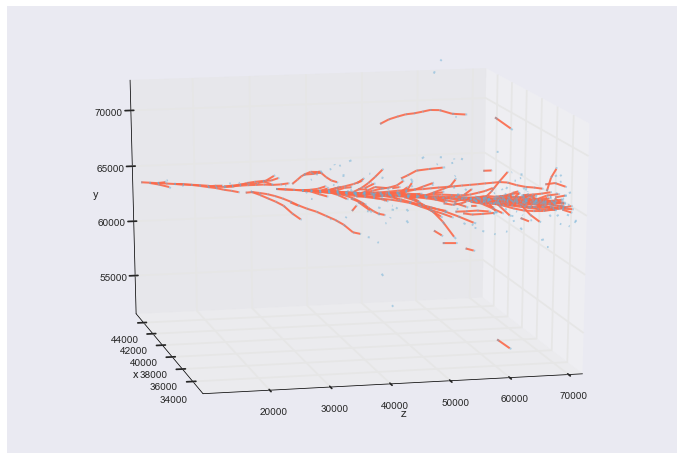

In [75]:
ind = pmc_train.sample(frac=0.01).Event_id.values
data = combine_mc_bg(pmc_train, pbg_train, ind, bg_frac = 0.0005)[0]

event_id = set(data.event_id)
event_id.remove(-999)

sons, parents = construct_signal_pairs(data, list(event_id)[1], 0.4)

sons = np.asarray(sons)
parents = np.asarray(parents)

plot_pairs(parents, sons, data[data.event_id == list(event_id)[1]])
plt.show()

In [22]:
# prepare pairwise classifier

In [23]:
ind = pmc_train.sample(frac=0.1).Event_id.values
train_data = combine_mc_bg(pmc_train, pbg_train, ind, bg_frac = 0.1)[0]

np.random.seed(42)
signal_train_sample = generate_training_sample_signal(train_data, ip_threshold=0.4)

np.random.seed(42)
noise_train_sample = generate_training_sample_noise(train_data)

print 'Signal part size: ' + str(len(signal_train_sample))
print 'Noise part size: ' + str(len(noise_train_sample))

Z coords generated
('Number of BG basetracks:', 956274)
('Number of MC events:', 184)
('Number of MC events in bounds:', 133)
Signal part size: 48359
Noise part size: 71123


In [24]:
df = np.random.permutation(np.concatenate([noise_train_sample, signal_train_sample]))

svm = SVC(C = 10, probability = True)
svm.fit(df[:50000, :8], df[:50000, 8])

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [28]:
# sequential cleaning algorithm

In [81]:
@jit
def svm_iterative_processing(data, classifier, threshold = 0.98, number_iterations = 1, box_size = 3000):
    every_iteration_data = []
    for _ in range(number_iterations):
        data = shower_finder_iterative(data, classifier, threshold = threshold, box_size=box_size)
        every_iteration_data.append(np.copy(data))
    return every_iteration_data

@jit
def find_similar_iterative(track, next_layer, classifier, threshold, box_size):
    
    track = np.array(track, dtype = float)
    indexes = np.arange(len(next_layer))
    
    track_cont = compute_track_continuation(track)
    bool_index = (abs(next_layer[:, 0] - track_cont[0]) < box_size) & (abs(next_layer[:, 1] - track_cont[1]) < box_size)
    next_layer = next_layer[bool_index]
    indexes = indexes[bool_index]
    
    if len(next_layer) == 0:
        return -1
    dist = classifier.predict_proba(compute_features(np.repeat(np.array([track]), len(next_layer), 0)[:, :6].astype(float), next_layer[:, :6].astype(float)))[:, 1]
    son = np.argmax(dist)
    if dist[son] > threshold:
        return indexes[son]
    else:
        return -1
    
@jit
def clear_layer_iterative(to_clear, to_compare, classifier, threshold, box_size):
    if (len(to_clear) == 0):
        return to_clear
    tracks_to_leave = np.apply_along_axis(arr=to_clear, axis=1, func1d=find_similar_iterative, next_layer = to_compare, classifier = classifier, threshold =  threshold, box_size = box_size)
    bool_leave = tracks_to_leave >= 0
    to_compare[tracks_to_leave[bool_leave], -1] = to_clear[bool_leave, -1] + 1
    
    return np.concatenate([to_clear[np.logical_or(bool_leave, to_clear[:, -1] > 3)], to_compare])

@jit
def shower_finder_iterative(data, classifier, number_of_iterations = 1, threshold = 0.98, box_size = 3000, start_plate = 0):
    mod_data = np.ones((data.shape[0],data.shape[1] + 1))
    mod_data[:,:-1] = data
    data = mod_data
    
    layers = list(set(data[:, 2]))
    layers.sort()
    for i in range(start_plate ,len(layers) - 1):
        cleared_data = clear_layer_iterative(data[data[:, 2] == layers[i]], data[data[:, 2] == layers[i+1]], classifier, threshold, box_size)
        data = data[(data[:, 2] != layers[i]) & (data[:, 2] != layers[i+1])]
        data = np.concatenate([data, cleared_data])
    return data[data[:, 2] != layers[-1]][:, :-1]

In [26]:
# probabolistic cleaning algorithm

In [27]:
def svm_iterative_processing_proba(data, classifier, box_size = 3000):
    data = shower_finder_iterative_proba(data, classifier, box_size=box_size)
    return [data]

def find_similar_iterative_proba(track, next_layer, classifier, box_size):
    
    track = np.array(track, dtype = float)
    indexes = np.arange(len(next_layer))
    
    track_cont = compute_track_continuation(track)
    bool_index = (abs(next_layer[:, 0] - track_cont[0]) < box_size) & (abs(next_layer[:, 1] - track_cont[1]) < box_size)
    next_layer = next_layer[bool_index]
    indexes = indexes[bool_index]
    
    if len(next_layer) == 0:
        return np.array([-1., 0.])
    dist = classifier.predict_proba(compute_features(np.repeat(np.array([track]), len(next_layer), 0)[:, :6].astype(float), next_layer[:, :6].astype(float)))[:, 1]
    son = np.argmax(dist)

    return np.array([indexes[son], dist[son]])

def clear_layer_iterative_proba(to_clear, to_compare, classifier, box_size):
    if (len(to_clear) == 0):
        return to_clear
    
    result = np.apply_along_axis(arr=to_clear, axis=1, func1d=find_similar_iterative_proba, next_layer = to_compare, classifier = classifier, box_size = box_size)
    indexes, proba = result[:, 0], result[:, 1]
    
    positive_index = indexes >= 0
    zero_proba = to_clear[:, -1] == 0
    big_proba = proba >= 0.7 # important value!
    
    first = ~((positive_index == 0) + (zero_proba != 0) + (big_proba==0))
    second = ~((positive_index == 0) + (zero_proba == 0) + (big_proba==0))
    
    to_compare[np.array(indexes[first], dtype = int), -1] = to_clear[first, -1] * (1 - proba[first])
    to_compare[np.array(indexes[first], dtype = int), -2] = to_clear[first, -2] + 1
    
    to_compare[np.array(indexes[second], dtype = int), -1] = 1 - proba[second]
    to_compare[np.array(indexes[second], dtype = int), -2] = 1
    
    return np.concatenate([to_clear, to_compare])

def shower_finder_iterative_proba(data, classifier, number_of_iterations = 1, box_size = 3000, start_plate = 0):
    mod_data = np.zeros((data.shape[0],data.shape[1] + 2))
    mod_data[:,:-2] = data
    data = mod_data
    
    layers = list(set(data[:, 2]))
    layers.sort()
    for i in range(start_plate ,len(layers) - 1):
        cleared_data = clear_layer_iterative_proba(data[data[:, 2] == layers[i]], data[data[:, 2] == layers[i+1]], classifier, box_size)
        data = data[(data[:, 2] != layers[i]) & (data[:, 2] != layers[i+1])]
        data = np.concatenate([data, cleared_data])
    

    layers.reverse()
    for i in range(start_plate ,len(layers) - 1):
        cleared_data = clear_layer_reverse_iterative_proba(data[data[:, 2] == layers[i+1]], data[data[:, 2] == layers[i]], classifier, box_size)
        data = data[(data[:, 2] != layers[i]) & (data[:, 2] != layers[i+1])]
        data = np.concatenate([data, cleared_data])
    
    return data


def clear_layer_reverse_iterative_proba(to_clear, to_compare, classifier, box_size):
    if (len(to_clear) == 0):
        return to_clear
    
    result = np.apply_along_axis(arr=to_clear, axis=1, func1d=find_similar_iterative_proba, next_layer = to_compare, classifier = classifier, box_size = box_size)
    indexes, proba = result[:, 0], result[:, 1]
    
    positive_index = indexes >= 0
    big_proba = proba >= 0.7
    
    first = ~((positive_index == 0) + (big_proba==0))
    to_clear[first, -1] = to_compare[np.array(indexes[first], dtype = int), -1]

    return np.concatenate([to_clear, to_compare])

## Cleaning algorithm performance

In [88]:
np.random.seed(1)
ind = pmc_val.sample(frac=0.02).Event_id.values
cv_data = combine_mc_bg(pmc_val, pbg_val, ind, bg_frac = 0.01)[0]

Z coords generated
('Number of BG basetracks:', 95627)
('Number of MC events:', 37)
('Number of MC events in bounds:', 30)


In [89]:
%%time
cleared_data = svm_iterative_processing(cv_data.values, svm, threshold = 0.9, number_iterations=5, box_size=100)

CPU times: user 43.7 s, sys: 25.3 ms, total: 43.7 s
Wall time: 43.9 s


In [90]:
cleared_data = map(lambda x: pd.DataFrame(x, columns = cv_data.columns), cleared_data)
signal = [np.sum(cv_data.signal == True)]
noise = [np.sum(cv_data.signal == False)]

for data in cleared_data:
    signal.append(np.sum(data.signal == True))
    noise.append(np.sum(data.signal == False))
    
print "Signal dynamic: " + str(signal)
print "Noise dynamic: " + str(noise)

Signal dynamic: [17813, 9025, 7544, 7038, 6863, 6685]
Noise dynamic: [95627, 105, 12, 12, 12, 12]


In [ ]:
# idea: reweight probabilities according to neighboorhood of every track along layers.

In [100]:
%%time
cleared_data = svm_iterative_processing_proba(cv_data.values, svm,  box_size=100)

CPU times: user 48.4 s, sys: 27.1 ms, total: 48.4 s
Wall time: 48.6 s


In [101]:
cleared_data = map(lambda x: pd.DataFrame(x, columns = list(cv_data.columns) + ['sequence_length','proba']), cleared_data)

proba = np.copy(cleared_data[0].proba)
proba[proba > 0] = 1 - proba[proba > 0]
print roc_auc_score(cleared_data[0].signal, proba)

thres = 0.9

print "Saved signal: " + str(np.sum(cleared_data[0].signal[proba > thres]))
print "Saved noise: " + str(cv_data[proba > thres].signal.count() - np.sum(cleared_data[0].signal[proba > thres]))

0.807127708386
Saved signal: 10665.0
Saved noise: 209.0


## CRF algorithm on sequences

In [89]:
%%time
np.random.seed(1)
ind = pmc_train.sample(frac=0.02).Event_id.values
train_data = combine_mc_bg(pmc_train, pbg_train, ind, bg_frac = 0.1)[0]

signal_sequences = extract_sequences(train_data[train_data.signal == 1].values)
noise_sequences = extract_sequences(train_data[train_data.signal == 0].values)

print "Signal length: {}".format(len(signal_sequences))
print "Noise length: {}".format(len(noise_sequences))

sequences = signal_sequences + noise_sequences
y_train = np.zeros(len(sequences))
y_train[:len(signal_sequences)] += 1

y_train = y_train.astype(int)

Z coords generated
('Number of BG basetracks:', 956274)
('Number of MC events:', 37)
('Number of MC events in bounds:', 27)
Signal length: 2290
Noise length: 13331
CPU times: user 52min 34s, sys: 4.04 s, total: 52min 38s
Wall time: 52min 53s


In [90]:
feature_sequences = []
y_sequences = []
for i in xrange(len(sequences)):
    next_sequence = np.zeros((len(sequences[i]) - 1, 8))
    for j in range(len(sequences[i]) - 1):
        next_sequence[j] = compute_features(sequences[i][j].reshape(1, -1), sequences[i][j+1].reshape(1, -1))
    feature_sequences.append(next_sequence)
    y_sequences.append(np.repeat(y_train[i], len(next_sequence)))

In [91]:
X_train_sequences, X_test_sequences, y_train_sequences, y_test_sequences = train_test_split(feature_sequences, y_sequences, test_size = 0.2)

In [92]:
model = ChainCRF()
ssvm = FrankWolfeSSVM(model=model, C=50, max_iter=20)
ssvm.fit(X_train_sequences, y_train_sequences)

FrankWolfeSSVM(C=50, batch_mode=False, check_dual_every=10, do_averaging=True,
        line_search=True, logger=None, max_iter=20,
        model=ChainCRF(n_states: 2, inference_method: max-product),
        n_jobs=1, random_state=None, sample_method='perm',
        show_loss_every=0, tol=0.001, verbose=0)

In [93]:
accuracy_score(np.array(map(lambda x: x[0], y_test_sequences)), np.array(map(lambda x: x[0], ssvm.predict(X_test_sequences))))

0.98880000000000001

## DBSCAN

## LSTM

# Final results

In [79]:
np.random.seed(1)
ind = pmc_test.sample(frac=0.1).Event_id.values
test_data = combine_mc_bg(pmc_test, pbg_test, ind, bg_frac = 1)[0]

Z coords generated
('Number of BG basetracks:', 8196633)
('Number of MC events:', 158)
('Number of MC events in bounds:', 119)


ET: 30 min - 2.5kk

In [ ]:
%%time
cleared_data = svm_iterative_processing(test_data.values, svm, threshold = 0.9, number_iterations=5, box_size=100)

CPU times: user 7h 29min 11s, sys: 42 s, total: 7h 29min 53s
Wall time: 7h 31min 12s


In [83]:
cleared_data = map(lambda x: pd.DataFrame(x, columns = test_data.columns), cleared_data)
signal = [np.sum(test_data.signal == True)]
noise = [np.sum(test_data.signal == False)]

for data in cleared_data:
    signal.append(np.sum(data.signal == True))
    noise.append(np.sum(data.signal == False))
    
print "Signal dynamic: " + str(signal)
print "Noise dynamic: " + str(noise)

Signal dynamic: [75960, 42486, 34696, 32080, 31056, 30126]
Noise dynamic: [8196633, 626383, 88844, 33384, 30698, 29845]


In [88]:
very_important_results = cleared_data

(31056, 3)


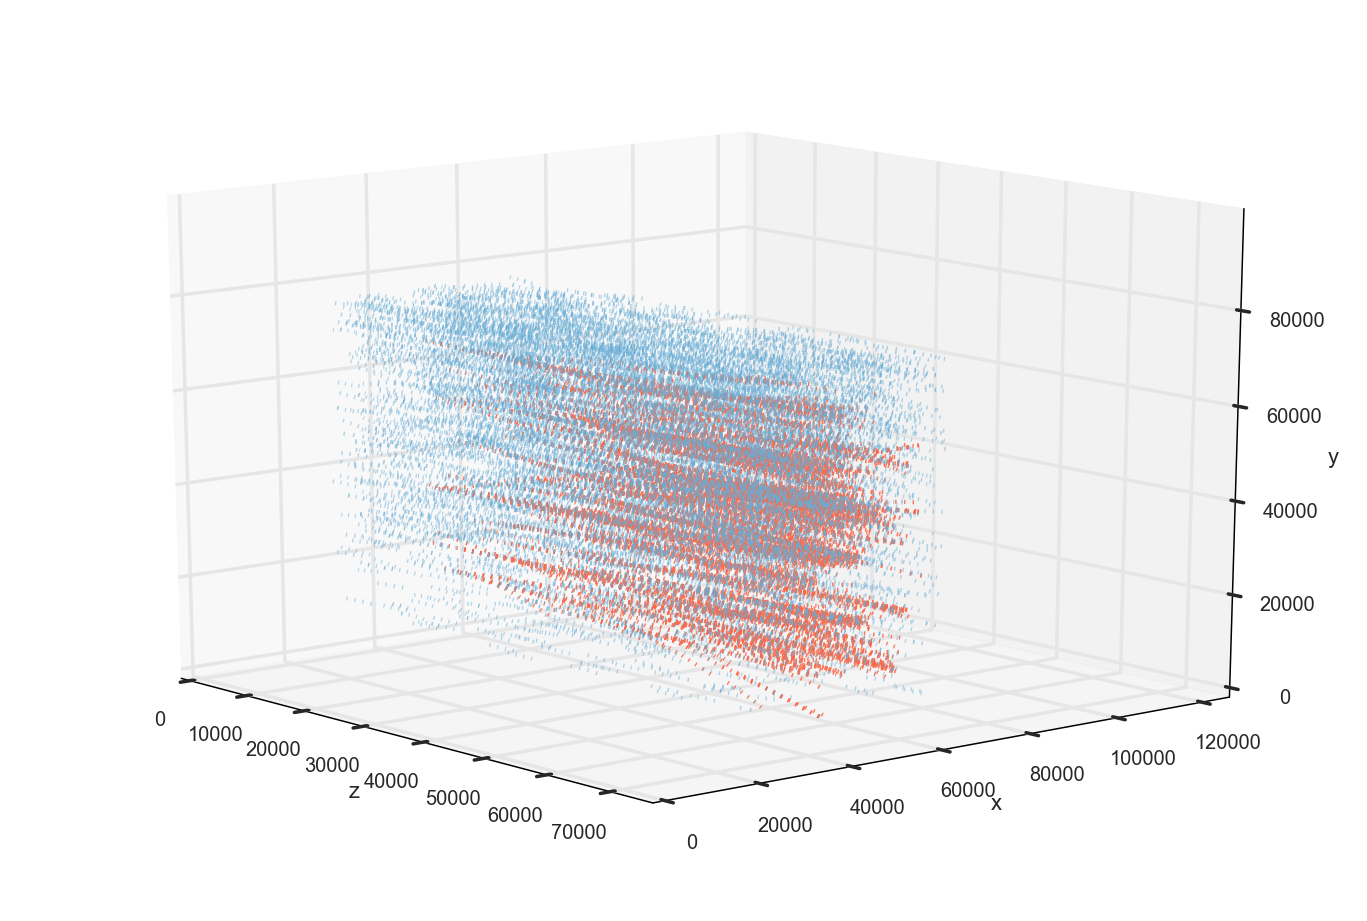

In [105]:
plot_bg_and_mc(cleared_data[3][cleared_data[3].signal == 0], cleared_data[3][cleared_data[3].signal == 1])

In [94]:
sequences_test = extract_sequences_svm(cleared_data[3].values)

In [86]:
cleared_data[3].to_csv('data_cleared_8kk')

In [95]:
print np.concatenate(sequences_test).shape
print np.sum(np.unique(np.concatenate(sequences_test), axis = 0)[:, 7] == 1)
print np.sum(np.unique(np.concatenate(sequences_test), axis = 0)[:, 7] == 0)

(160624, 9)
30765
30066


In [96]:
feature_sequences_test = []
for i in xrange(len(sequences_test)):
    next_sequence = np.zeros((len(sequences_test[i]) - 1, 8))
    for j in range(len(sequences_test[i]) - 1):
        next_sequence[j] = compute_features(sequences_test[i][j].reshape(1, -1), sequences_test[i][j+1].reshape(1, -1))
    feature_sequences_test.append(next_sequence)

In [97]:
result = ssvm.predict(feature_sequences_test)

In [98]:
left_sequences = []
for i in range(len(feature_sequences_test)):
    if np.sum(result[i]) / len(result[i]) > 0.5:
        left_sequences.append(sequences_test[i])

In [99]:
left_tracks = np.concatenate(left_sequences)

In [100]:
left_tracks.shape

(125818, 9)

In [101]:
print np.sum(np.unique(left_tracks, axis = 0)[:, 7] == 1)
print np.sum(np.unique(left_tracks, axis = 0)[:, 7] == 0)

29676
5257


In [102]:
final = pd.DataFrame(np.unique(left_tracks, axis = 0), columns=cleared_data[0].columns)

(29676, 3)


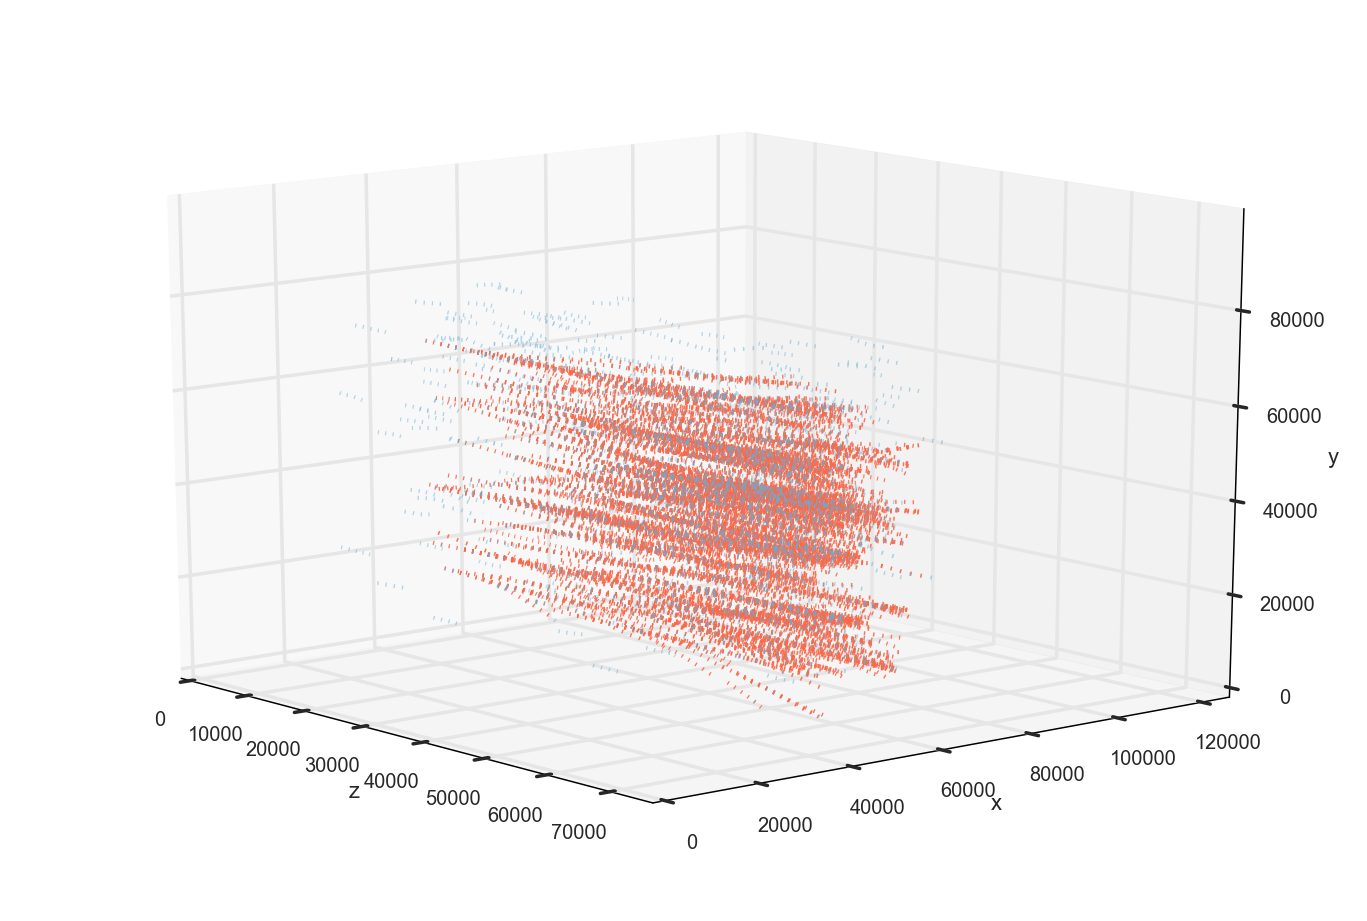

In [104]:
plt.figure(figsize=(14,8))
seaborn.set_style("whitegrid")
plot_bg_and_mc(final[final.signal == 0], final[final.signal == 1])

## Precision / Recall Graph, 1st iteration

In [ ]:
precision = []
recall = []

for proba in np.linspace(0.5, 0.99, 10):
    prec = []
    rec = []
    for i in range(3, 8):
        np.random.seed(i)
        ind = pmc_test.sample(frac=0.05).Event_id.values
        test_data = combine_mc_bg(pmc_test, pbg_test, ind, bg_frac = 0.1)[0]
        data = svm_iterative_processing(test_data.values, svm, threshold = proba, number_iterations=1, box_size=100)[0]
        n_prec, n_rec = precision_recall(pd.DataFrame(data, columns=test_data.columns), np.sum(test_data.signal == 1))
        prec.append(n_prec)
        rec.append(n_rec)
    precision.append(prec)
    recall.append(rec)

Z coords generated
('Number of BG basetracks:', 819663)
('Number of MC events:', 79)
('Number of MC events in bounds:', 51)
Z coords generated
('Number of BG basetracks:', 819663)
('Number of MC events:', 79)
('Number of MC events in bounds:', 65)


In [448]:
np_precision = np.array(precision)
np_recall = np.array(recall)

In [456]:
np.std(np_precision, axis = 1)

array([ 0.02231977,  0.02207876,  0.02176172,  0.02162716,  0.02120135,
        0.020933  ,  0.02037273,  0.01890477,  0.01804535,  0.0150053 ])

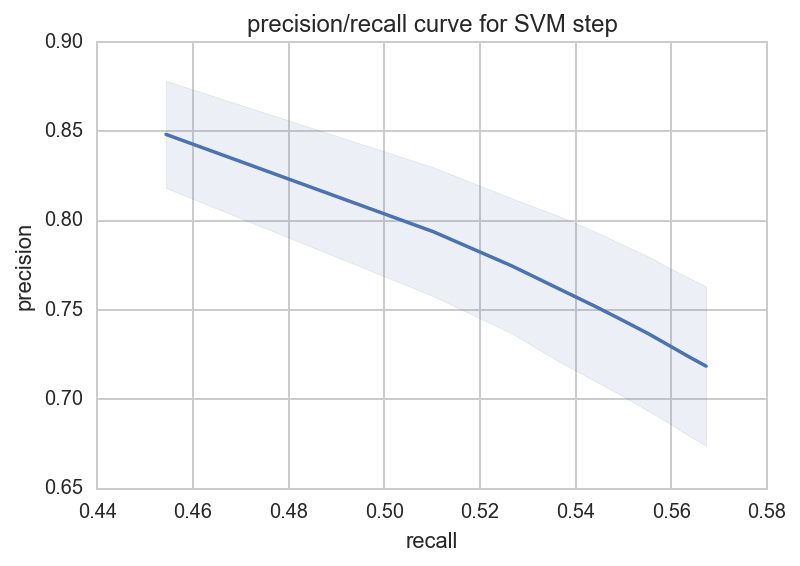

In [458]:
plt.plot(np.mean(np_recall, axis = 1), np.mean(np_precision, axis = 1))
plt.fill_between(np.mean(np_recall, axis = 1), np.mean(np_precision, axis = 1) - 2 * np.std(np_precision, axis = 1), np.mean(np_precision, axis = 1) + 2 * np.std(np_precision, axis = 1), alpha = 0.1)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('precision/recall curve for SVM step')

In [53]:

def svm_iterative_processing_proba(data, classifier, threshold = 0.98, number_iterations = 1, box_size = 3000):
    every_iteration_data = []
    for _ in range(number_iterations):
        meta_data = shower_finder_iterative_proba(data, classifier, box_size=box_size)
        every_iteration_data.append(meta_data)
        data = data[meta_data[:, 0] > threshold]
    return every_iteration_data


def find_similar_iterative_proba(track, next_layer, classifier, box_size):
    
    track = np.array(track, dtype = float)
    indexes = np.arange(len(next_layer))
    
    track_cont = compute_track_continuation(track)
    bool_index = (abs(next_layer[:, 0] - track_cont[0]) < box_size) & (abs(next_layer[:, 1] - track_cont[1]) < box_size)
    next_layer = next_layer[bool_index]
    indexes = indexes[bool_index]
    
    if len(next_layer) == 0:
        return -1, -1
    dist = classifier.predict_proba(compute_features(np.repeat(np.array([track]), len(next_layer), 0)[:, :6].astype(float), next_layer[:, :6].astype(float)))[:, 1]
    son = np.argmax(dist)
    return indexes[son], dist[son]


def shower_finder_iterative_proba(data, classifier, box_size = 3000, start_plate = 0):
    meta_data = np.zeros((len(data), 2))
    
    layers = list(set(data[:, 2]))
    layers.sort()
    for i in range(start_plate ,len(layers) - 1):
        
        bool_1 = data[:, 2] == layers[i]
        layer = data[bool_1]
        
        bool_2 = data[:, 2] == layers[i + 1]
        next_layer = data[bool_2]

        probas = []
        indexes = []
        for j in xrange(len(layer)):
            index, proba = find_similar_iterative_proba(layer[j], next_layer, classifier, box_size)
            if proba == -1:
                probas.append(0)
                indexes.append(-1)
            else:
                probas.append(proba)
                indexes.append(index)
                
        
        meta_data[bool_1, 0] = np.array(probas, dtype = float)
        indexes = np.array(indexes)
        
        ind = -1 * np.ones(len(indexes))
        ind[indexes > -1] = np.arange(len(data))[bool_2][indexes[indexes > -1]]
        meta_data[bool_1, 1] = ind
        
    return meta_data

In [72]:
np.random.seed(1000)
ind = pmc_test.sample(frac=0.05).Event_id.values
test_data = combine_mc_bg(pmc_test, pbg_test, ind, bg_frac = 0.1)[0]


Z coords generated
('Number of BG basetracks:', 819663)
('Number of MC events:', 79)
('Number of MC events in bounds:', 60)


In [73]:
%%time 
data = svm_iterative_processing_proba(test_data.values, svm, threshold = 0.95, number_iterations=1, box_size=100)[0]

CPU times: user 37min 22s, sys: 2.06 s, total: 37min 24s
Wall time: 37min 33s


In [74]:
from sklearn.metrics import precision_recall_curve

pr, re, _ = precision_recall_curve(test_data.signal.values, data[:, 0] ,pos_label=1)

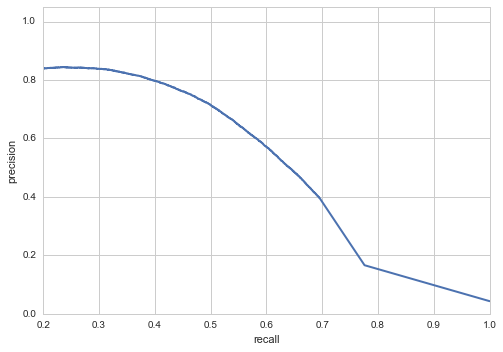

In [78]:
plt.clf()
seaborn.set_style("whitegrid")
plt.plot(re, pr,lw = 2)
plt.ylim([0.0, 1.05])
plt.xlim([0.2, 1.0])
plt.xlabel('recall')
plt.ylabel('precision')

In [76]:
from sklearn.metrics import roc_auc_score

roc_auc_score(test_data.signal.values, data[:, 0])

0.85339383272007008